### Portfolio Optimization - Wasserstein Ball and Reinforcement Learning

* [1. Import Packages](#1)
* [2. Stock Simulation Function](#2)  
* [3. ANN for mapping State to action](#3)      
* [4. Function toretun portfolio value and Risk Measure](#4)    
* [5. Training](#5)

<a id='1'></a>
### 1. Import Packages

In [1]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
import numpy.matlib
from scipy.stats import norm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import seaborn as sns

<a id='2'></a>
### 2. Stock Simulation Function

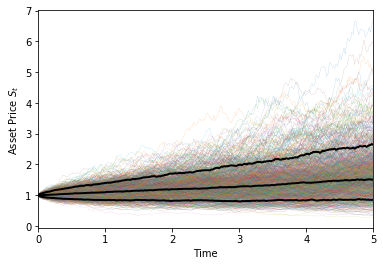

In [2]:
# %%
def SimPath(Ndt, S0, mu, sigma, T, Nsims):
    
    dt = T/Ndt
    
    S = np.zeros((Nsims,Ndt+1))
    S[:,0] = S0
    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.randn(Nsims)
        S[:,i+1] = S[:,i] * np.exp((mu-0.5*sigma**2)*dt + sigma*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S
        


# %%
t, S = SimPath(252,1, 0.1, 0.2, 5, 1000)

# %%
Ndt=20

S0=1

T=5

Nsims=500


plt.plot(t, S.T,linewidth=0.1)
plt.plot(t,np.quantile(S,[0.1, 0.5, 0.9],axis=0).T,color='k',linewidth=2)
plt.xlabel("Time")
plt.ylabel("Asset Price $S_t$")
plt.xlim([0,5])
plt.show()

<a id='3'></a>
### 3. ANN for mapping state and weights
In this function we pass the prices of the instruments and get the weights across time

In [9]:
# %%
class MyNet(nn.Module):
    
    def __init__(self, n ):
        super(MyNet, self).__init__()
        
        # 3 input layer (t,S), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 4 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, 3)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)
        
        return y

In [4]:
# t, S1 = SimPath(Ndt, 1, .05, .1, T, Nsims)
# t, S2 = SimPath(Ndt, 1, .06, .12, T, Nsims)

# t

# x=np.zeros((Nsims,Ndt+1,3))
# x.shape 

# x[:,:,0] = np.matlib.repmat(t,Nsims, 1)

# x[:,:,1] = S1

# x[:,:,2] = S2

# xt = torch.tensor(x, dtype=torch.float)

# xt[:,:-1,:].shape

torch.Size([500, 20, 3])

In [5]:
# #Compute wt
# wt = net(xt[:,:-1,:])
# #wt

NameError: name 'net' is not defined

In [ ]:
wt[:,:,1].shape

wt 

S1[:,:-1].shape

Val1= wt[:,:,0] * torch.tensor(S1[:,:-1], dtype=torch.float)
Val2= wt[:,:,1] * torch.tensor(S2[:,:-1], dtype=torch.float)
TotalVal = Val1 + Val2

TotalVal.shape

#Weights at time t 
#TotalVal[:, -1]

In [ ]:
wt.shape

In [ ]:
#output for one scenario
wt[0,:,:]

In [ ]:
#Weight at T for all scenarios 
wt[:,-1,:].shape

In [ ]:
Delta_t = torch.tensor(np.zeros((Nsims,Ndt,2)), dtype=torch.float)
Delta_t[:,:,0] = .75
Delta_t[:,:,1] = .25

Val1_index= Delta_t[:,:,0] * torch.tensor(S1[:,:-1], dtype=torch.float, requires_grad=True)
Val2_index= Delta_t[:,:,1] * torch.tensor(S2[:,:-1], dtype=torch.float, requires_grad=True)
TotalVal_index = Val1_index + Val2_index
#TotalVal_index[:, -1]
Delta_t[:,-1,:].shape
#np.array(TotalVal_index.detach())[3]

In [ ]:
#np.array(TotalVal.detach()).mean(axis =0)

In [ ]:
#plt.plot(np.array(TotalVal_index[:1].detach())[0])
#Visual plot to check if the error is reducing
plt.plot(np.array(TotalVal_index.detach())[2], label='Index')
plt.plot(np.array(TotalVal.detach())[2], label='Portfolio')
plt.legend()
plt.show()

In [ ]:
#plt.plot(np.array(TotalVal_index[:1].detach())[0])
#Visual plot to check if the error is reducing
plt.plot(np.array(TotalVal_index.detach()).mean(axis =0), label='Index')
plt.plot(np.array(TotalVal.detach()).mean(axis =0), label='Portfolio')
plt.legend()
plt.show()

In [ ]:
stats.wasserstein_distance(TotalVal_T.detach(),IndexVal_T.detach())

In [ ]:
TotalVal_T

In [ ]:
#stats.wasserstein_distance(1,2)
TotalVal_T

In [ ]:
IndexVal_T

<a id='3'></a>
### 3. Function to get the Return, risk measure and portfolio weights
This function fetches the Return, risk measure and portfolio path for each path

In [13]:
Ndt = 20
S1_T0 = 1
S2_T0 = 100
S3_T0 = 10
Nsims = 50

def SimTVaR(net, Ndt, T, Nsims, ReturnTensor):
    
    #The function is designed for 3 stocks. Can be customized for any number of stocks
    num_asset = 3    
           
    t, S1 = SimPath(Ndt, S1_T0, .05, .1, T, Nsims)
    t, S2 = SimPath(Ndt, S2_T0, .06, .12, T, Nsims)
    t, S3 = SimPath(Ndt, S3_T0, .06, .12, T, Nsims)
    
    x=np.zeros((Nsims,Ndt+1,num_asset+1))
    x[:,:,1] = S1
    xt = torch.tensor(x, dtype=torch.float)
    wt = net(xt[:,:-1,:])
    Val1= wt[:,:,0] * torch.tensor(S1[:,:-1], dtype=torch.float)
    Val2= wt[:,:,1] * torch.tensor(S2[:,:-1], dtype=torch.float)
    Val3= wt[:,:,2] * torch.tensor(S3[:,:-1], dtype=torch.float)
    TotalVal = Val1 + Val2 + Val3
    TotalVal_T = TotalVal[:,-1]
    
    #Index Delta and return
    Delta_t = torch.tensor(np.zeros((Nsims,Ndt,num_asset)), dtype=torch.float)
    Delta_t[:,:,0] = .50
    Delta_t[:,:,1] = .25
    Delta_t[:,:,2] = .25

    Val1_index= Delta_t[:,:,0] * torch.tensor(S1[:,:-1], dtype=torch.float, requires_grad=True)
    Val2_index= Delta_t[:,:,1] * torch.tensor(S2[:,:-1], dtype=torch.float, requires_grad=True)
    Val3_index= Delta_t[:,:,2] * torch.tensor(S3[:,:-1], dtype=torch.float, requires_grad=True)
    TotalVal_index = Val1_index + Val2_index + Val3_index
    IndexVal_T=TotalVal_index[:, -1]
    
    #wd = stats.wasserstein_distance(TotalVal_T.detach(),IndexVal_T.detach())
    #wd = stats.wasserstein_distance(wt[:,-1,0].detach(),Delta_t[:,-1,0].detach())
    #wass_dist = wt-Delta_t
    #wass_dist = wt[:,-1,:] - Delta_t[:,-1,:]
    wass_dist = (TotalVal_T - IndexVal_T)**2
    #wass_dist = torch.tensor(wd, dtype=torch.float, requires_grad=True)
    
    x2=np.zeros((Nsims,Ndt-1))
    Return = torch.tensor(x2, dtype=torch.float)
    Return.shape
    
    for i in range(1,Ndt-1):
        Return[:,i] = TotalVal[:,i+1] - TotalVal[:,i]
        
    TVaR = torch.var(Return)
    
    #TVaR = torch.tensor(np.percentile(Return.detach().numpy(), 1,axis=1), dtype=torch.float, requires_grad=True)
    
    return wt, Return, TVaR, TotalVal, TotalVal_index, TotalVal_T, IndexVal_T, wass_dist

In [7]:
net = MyNet(100)
#price = PutPrice(S0, K, T, 0, mu, sigma)
#PlotHedge(net)
optimizer = optim.Adam(net.parameters())

In [8]:
wt, Return, TVaR, TotalVal, TotalVal_T, TotalVal_index,IndexVal_T, wass_dist = SimTVaR(net, Ndt, S0, mu, sigma, T, Nsims, True)

NameError: name 'mu' is not defined

In [ ]:
torch.sum(wass_dist**2)+torch.sum(TVaR)

In [ ]:
torch.sum(wass_dist**2)

<a id='4'></a>
### 4. Training Function

50 Wass Dist: tensor(3.6014, grad_fn=<SumBackward0>)
TVaR: tensor(-3.6211, grad_fn=<SumBackward0>)


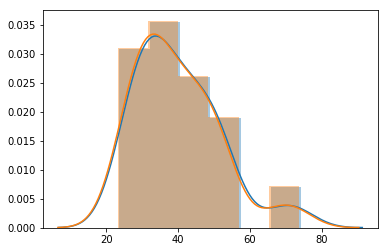

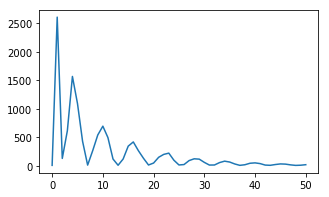

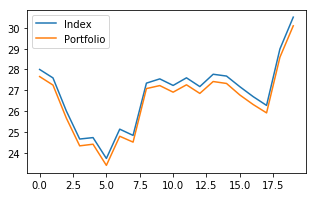

100 Wass Dist: tensor(0.0096, grad_fn=<SumBackward0>)
TVaR: tensor(-3.5570, grad_fn=<SumBackward0>)


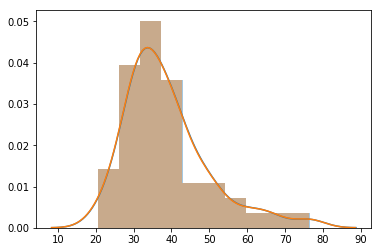

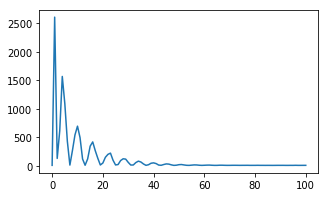

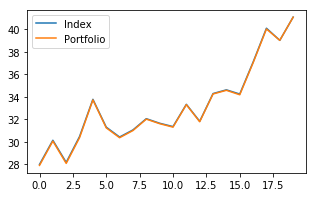

150 Wass Dist: tensor(0.0040, grad_fn=<SumBackward0>)
TVaR: tensor(-3.2552, grad_fn=<SumBackward0>)


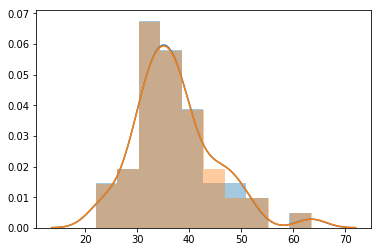

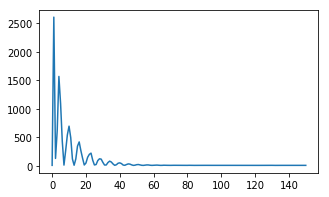

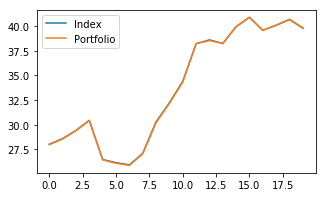

200 Wass Dist: tensor(0.0019, grad_fn=<SumBackward0>)
TVaR: tensor(-2.9966, grad_fn=<SumBackward0>)


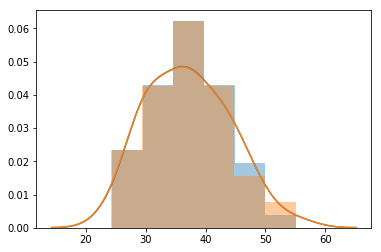

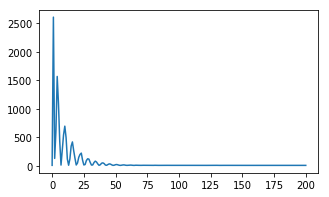

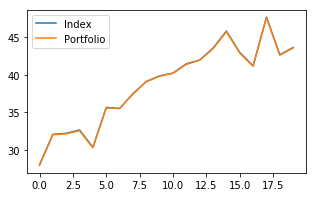

250 Wass Dist: tensor(0.0012, grad_fn=<SumBackward0>)
TVaR: tensor(-3.4693, grad_fn=<SumBackward0>)


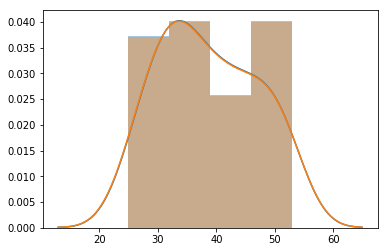

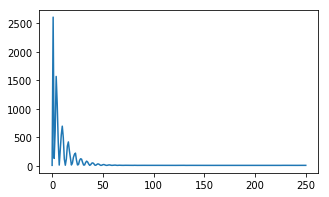

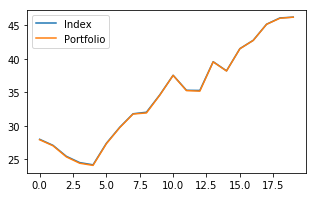

300 Wass Dist: tensor(0.0078, grad_fn=<SumBackward0>)
TVaR: tensor(-3.3580, grad_fn=<SumBackward0>)


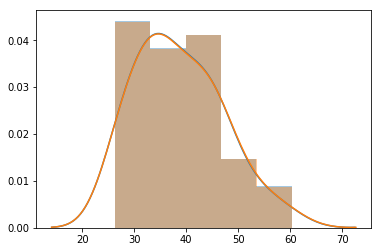

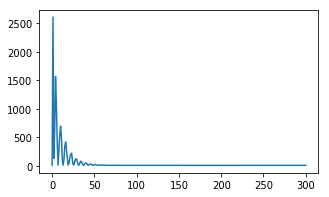

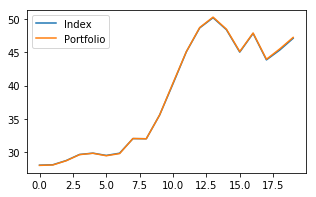

350 Wass Dist: tensor(0.0016, grad_fn=<SumBackward0>)
TVaR: tensor(-3.5386, grad_fn=<SumBackward0>)


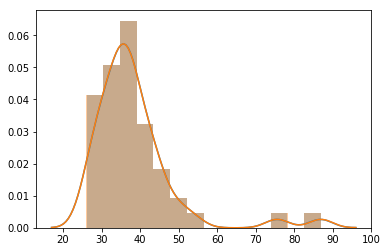

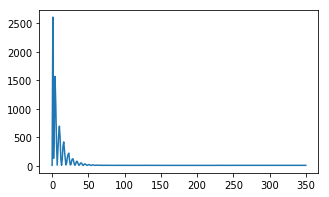

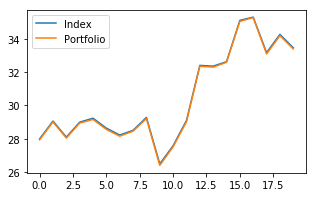

400 Wass Dist: tensor(0.0014, grad_fn=<SumBackward0>)
TVaR: tensor(-3.1102, grad_fn=<SumBackward0>)


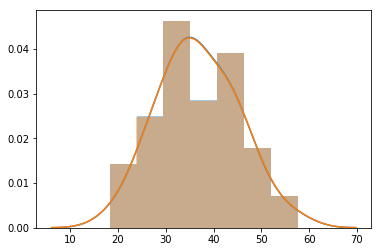

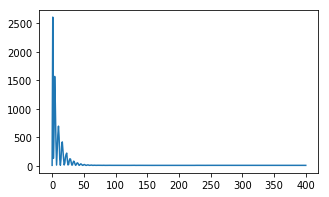

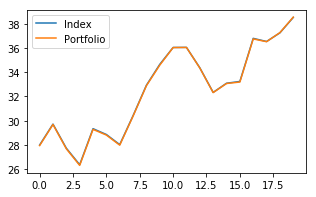

450 Wass Dist: tensor(0.0011, grad_fn=<SumBackward0>)
TVaR: tensor(-3.2679, grad_fn=<SumBackward0>)


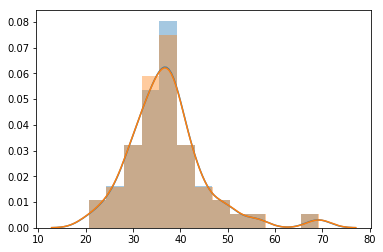

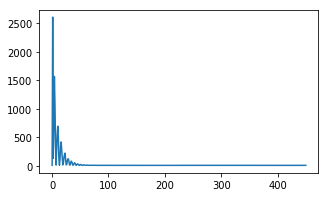

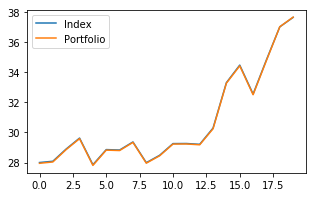

500 Wass Dist: tensor(0.0004, grad_fn=<SumBackward0>)
TVaR: tensor(-3.1649, grad_fn=<SumBackward0>)


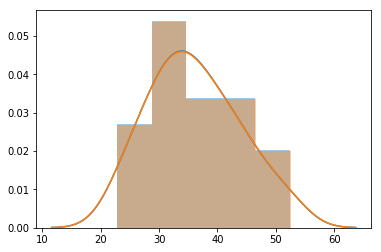

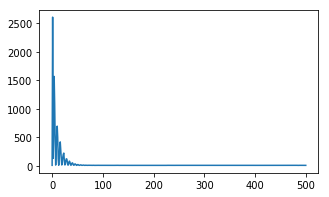

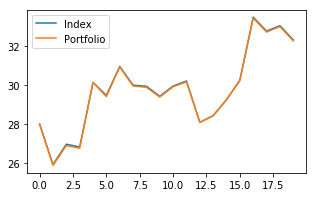

550 Wass Dist: tensor(0.0007, grad_fn=<SumBackward0>)
TVaR: tensor(-2.9297, grad_fn=<SumBackward0>)


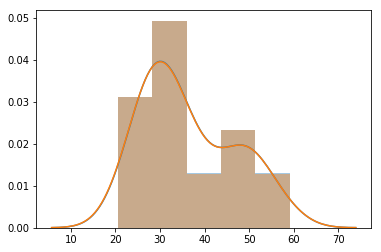

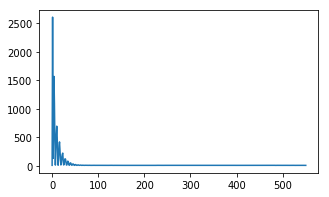

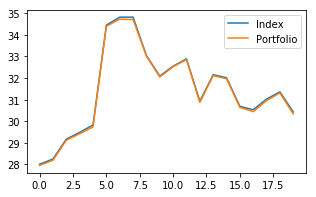

600 Wass Dist: tensor(0.0020, grad_fn=<SumBackward0>)
TVaR: tensor(-3.2204, grad_fn=<SumBackward0>)


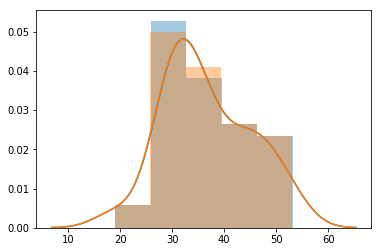

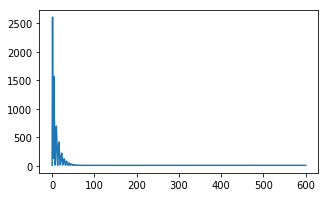

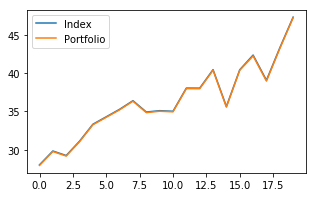

650 Wass Dist: tensor(0.0009, grad_fn=<SumBackward0>)
TVaR: tensor(-3.1707, grad_fn=<SumBackward0>)


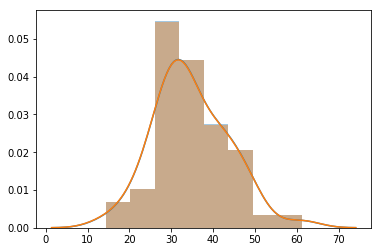

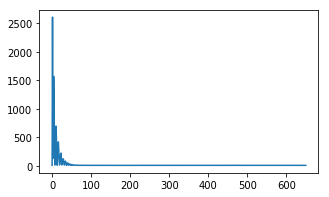

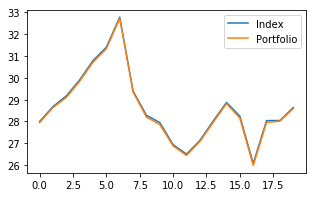

700 Wass Dist: tensor(0.0093, grad_fn=<SumBackward0>)
TVaR: tensor(-3.4788, grad_fn=<SumBackward0>)


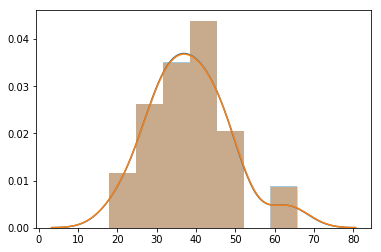

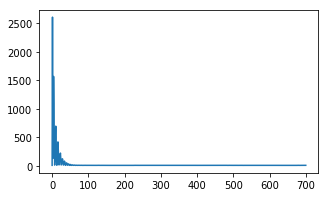

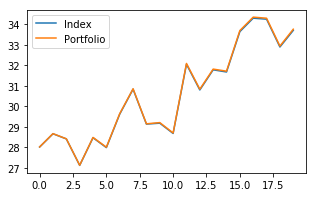

750 Wass Dist: tensor(0.0025, grad_fn=<SumBackward0>)
TVaR: tensor(-3.2430, grad_fn=<SumBackward0>)


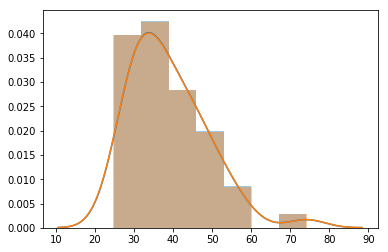

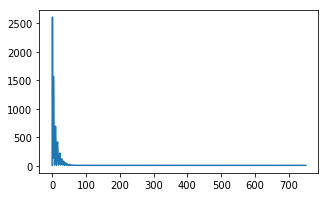

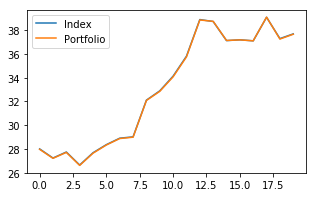

800 Wass Dist: tensor(0.0003, grad_fn=<SumBackward0>)
TVaR: tensor(-3.0626, grad_fn=<SumBackward0>)


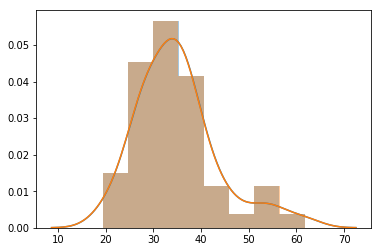

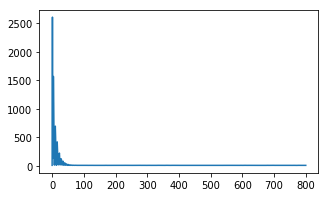

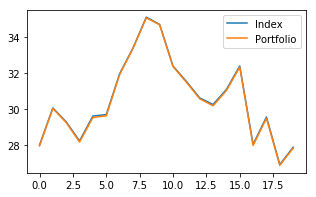

850 Wass Dist: tensor(0.0002, grad_fn=<SumBackward0>)
TVaR: tensor(-3.1801, grad_fn=<SumBackward0>)


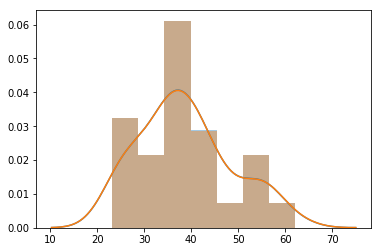

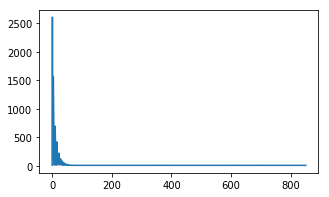

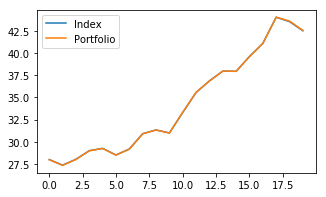

900 Wass Dist: tensor(0.0021, grad_fn=<SumBackward0>)
TVaR: tensor(-2.9046, grad_fn=<SumBackward0>)


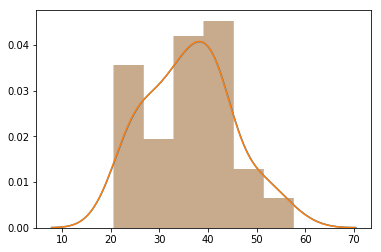

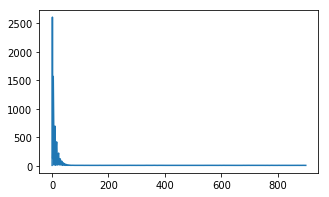

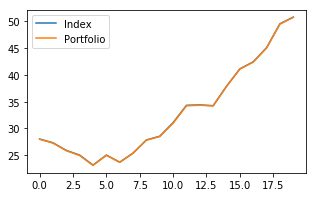

950 Wass Dist: tensor(0.0003, grad_fn=<SumBackward0>)
TVaR: tensor(-2.9267, grad_fn=<SumBackward0>)


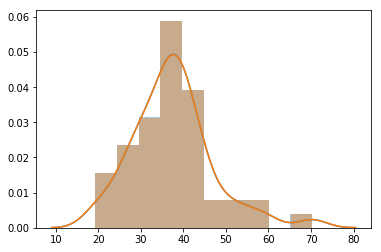

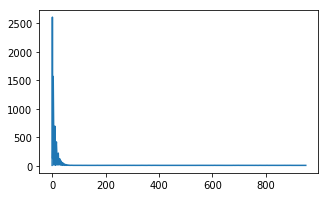

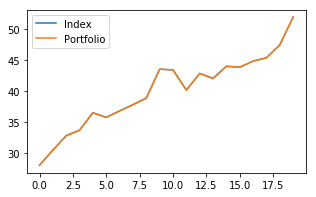

1000 Wass Dist: tensor(0.0075, grad_fn=<SumBackward0>)
TVaR: tensor(-3.1927, grad_fn=<SumBackward0>)


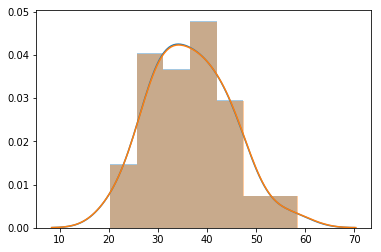

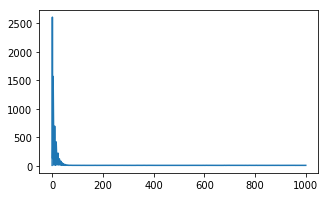

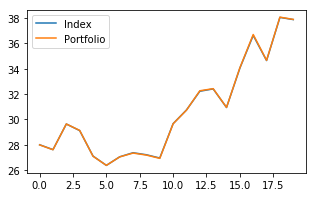

1050 Wass Dist: tensor(0.0040, grad_fn=<SumBackward0>)
TVaR: tensor(-2.9503, grad_fn=<SumBackward0>)


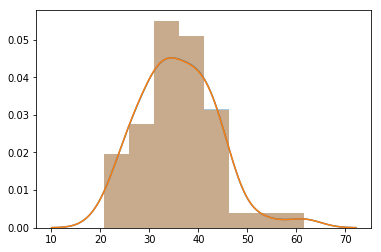

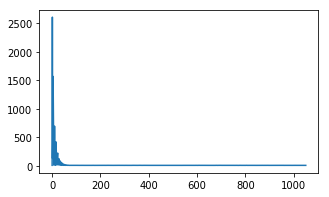

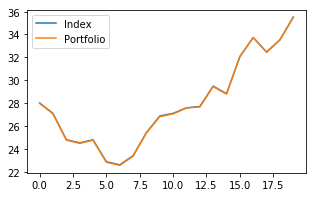

1100 Wass Dist: tensor(0.0030, grad_fn=<SumBackward0>)
TVaR: tensor(-3.3534, grad_fn=<SumBackward0>)


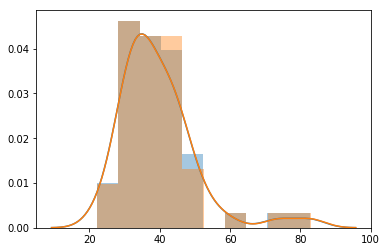

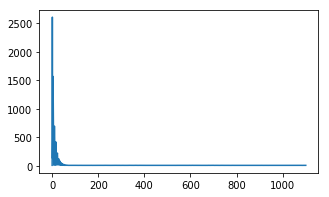

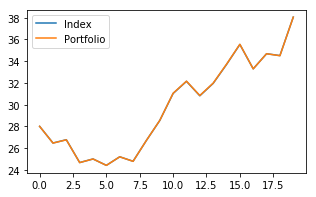

1150 Wass Dist: tensor(0.0002, grad_fn=<SumBackward0>)
TVaR: tensor(-3.9165, grad_fn=<SumBackward0>)


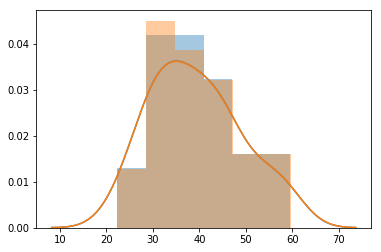

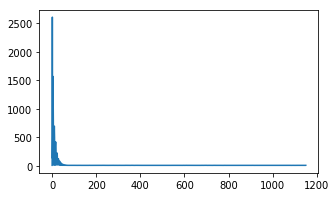

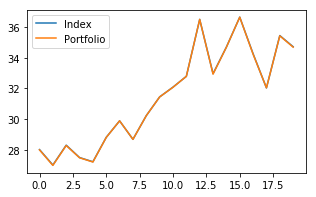

1200 Wass Dist: tensor(0.0003, grad_fn=<SumBackward0>)
TVaR: tensor(-2.8784, grad_fn=<SumBackward0>)


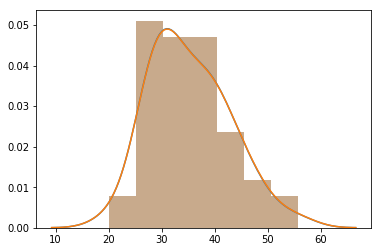

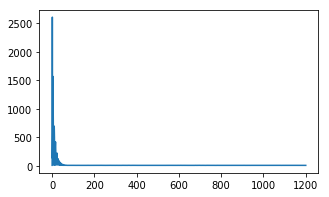

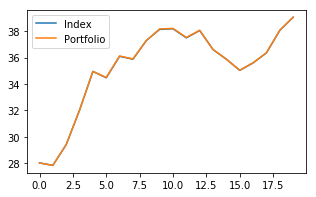

1250 Wass Dist: tensor(6.1155e-05, grad_fn=<SumBackward0>)
TVaR: tensor(-2.7105, grad_fn=<SumBackward0>)


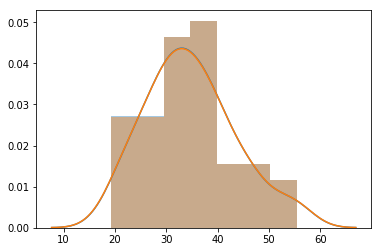

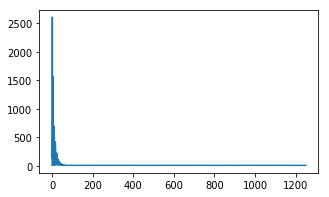

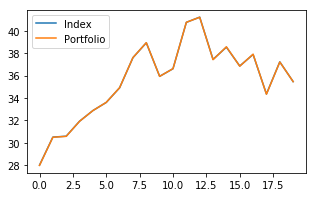

1300 Wass Dist: tensor(0.0007, grad_fn=<SumBackward0>)
TVaR: tensor(-2.9946, grad_fn=<SumBackward0>)


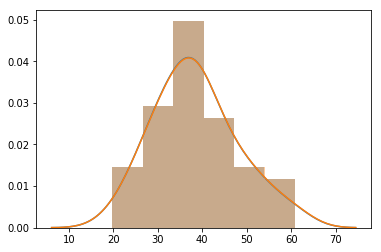

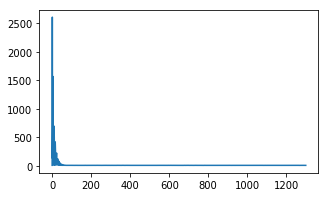

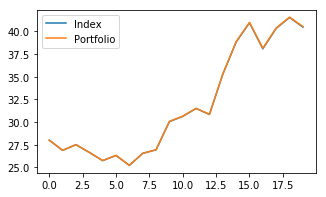

1350 Wass Dist: tensor(5.0813e-05, grad_fn=<SumBackward0>)
TVaR: tensor(-3.1256, grad_fn=<SumBackward0>)


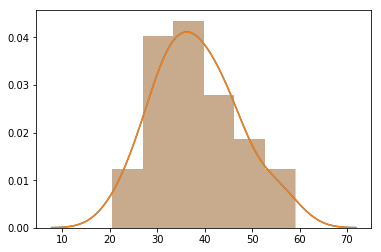

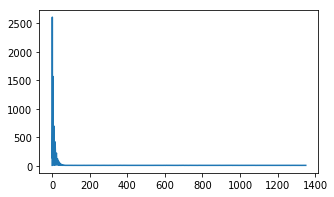

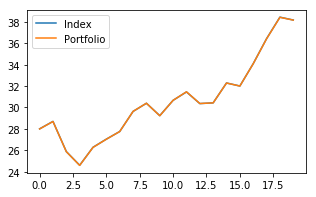

1400 Wass Dist: tensor(0.0018, grad_fn=<SumBackward0>)
TVaR: tensor(-3.3230, grad_fn=<SumBackward0>)


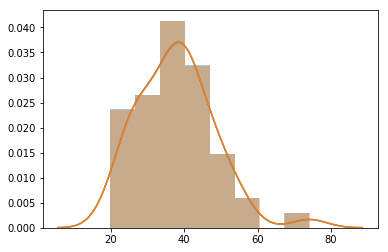

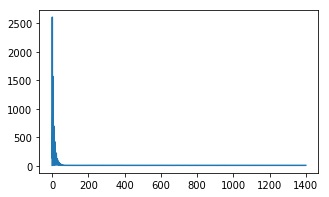

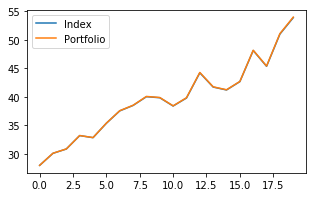

1450 Wass Dist: tensor(0.0005, grad_fn=<SumBackward0>)
TVaR: tensor(-3.0417, grad_fn=<SumBackward0>)


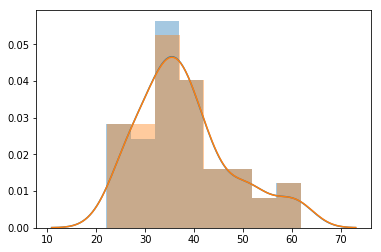

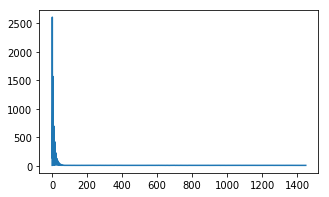

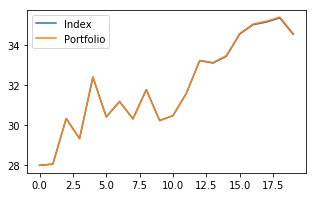

1500 Wass Dist: tensor(0.0001, grad_fn=<SumBackward0>)
TVaR: tensor(-3.2252, grad_fn=<SumBackward0>)


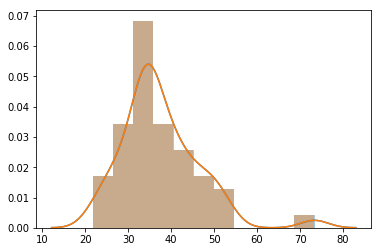

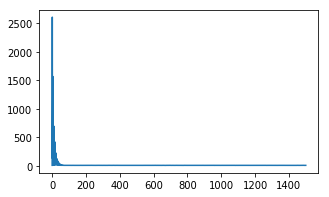

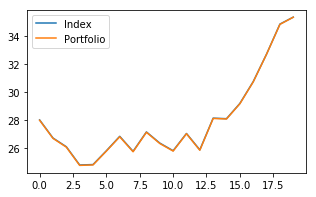

1550 Wass Dist: tensor(0.0006, grad_fn=<SumBackward0>)
TVaR: tensor(-2.8334, grad_fn=<SumBackward0>)


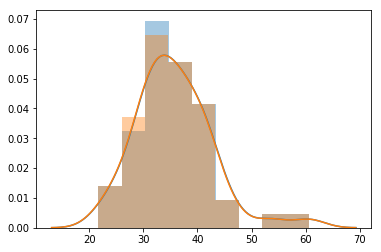

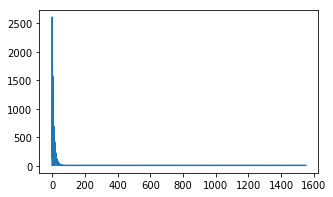

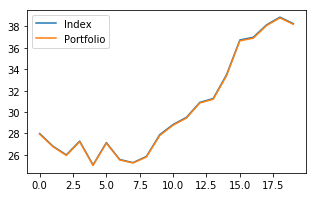

1600 Wass Dist: tensor(0.0005, grad_fn=<SumBackward0>)
TVaR: tensor(-3.1236, grad_fn=<SumBackward0>)


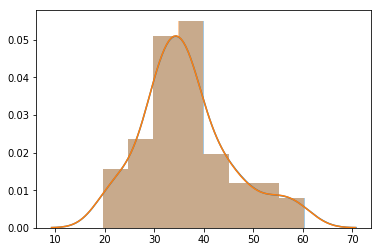

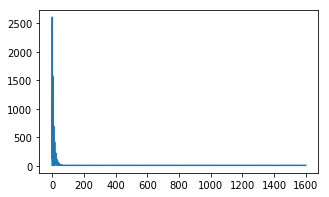

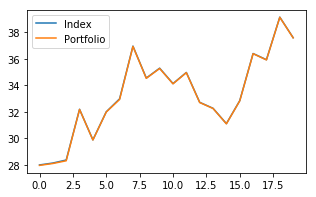

1650 Wass Dist: tensor(0.0002, grad_fn=<SumBackward0>)
TVaR: tensor(-2.6570, grad_fn=<SumBackward0>)


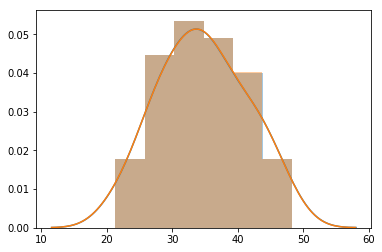

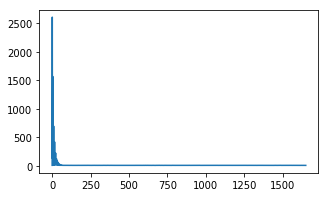

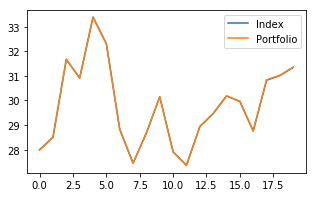

1700 Wass Dist: tensor(8.7774e-05, grad_fn=<SumBackward0>)
TVaR: tensor(-3.2900, grad_fn=<SumBackward0>)


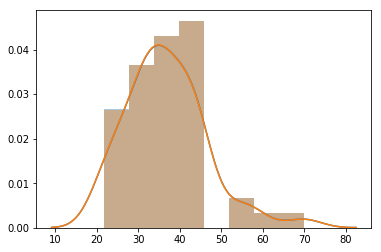

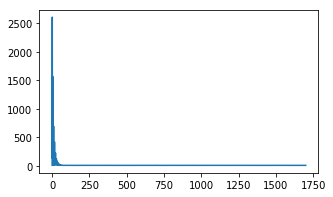

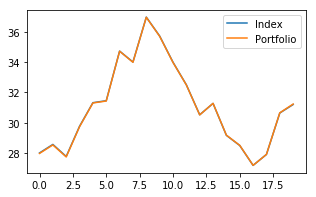

1750 Wass Dist: tensor(0.0009, grad_fn=<SumBackward0>)
TVaR: tensor(-3.1712, grad_fn=<SumBackward0>)


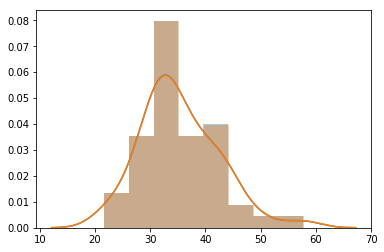

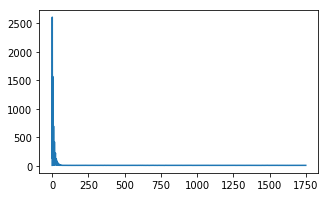

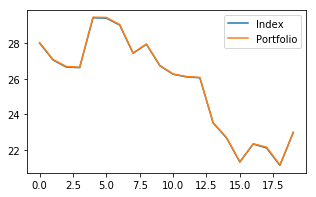

1800 Wass Dist: tensor(0.0003, grad_fn=<SumBackward0>)
TVaR: tensor(-2.7614, grad_fn=<SumBackward0>)


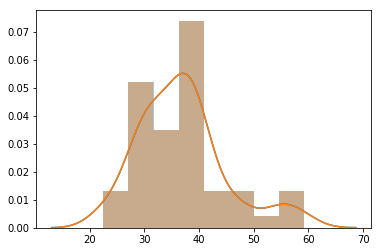

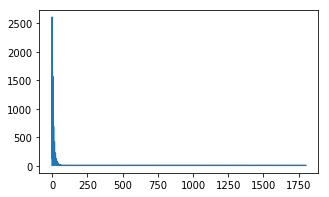

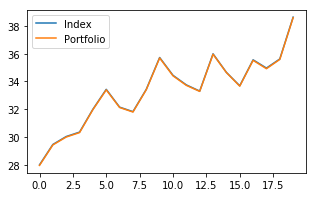

1850 Wass Dist: tensor(0.0002, grad_fn=<SumBackward0>)
TVaR: tensor(-3.0406, grad_fn=<SumBackward0>)


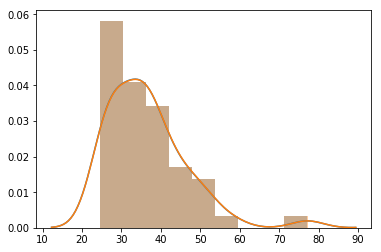

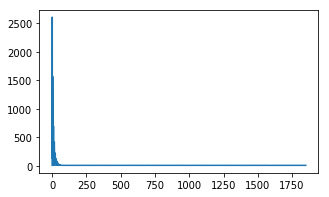

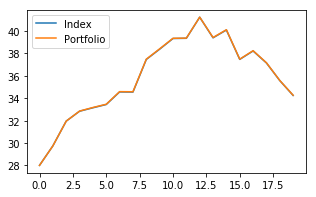

1900 Wass Dist: tensor(0.0136, grad_fn=<SumBackward0>)
TVaR: tensor(-3.0763, grad_fn=<SumBackward0>)


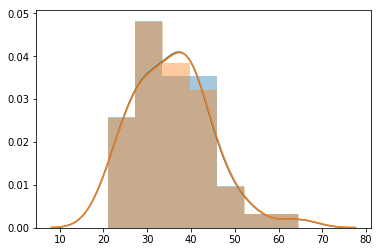

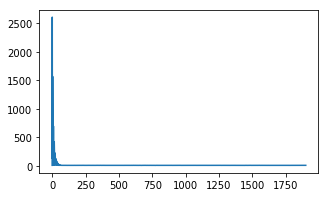

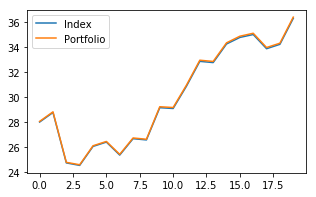

1950 Wass Dist: tensor(0.0002, grad_fn=<SumBackward0>)
TVaR: tensor(-3.2754, grad_fn=<SumBackward0>)


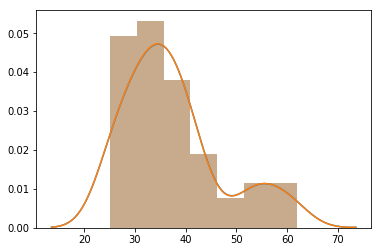

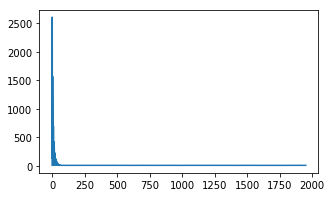

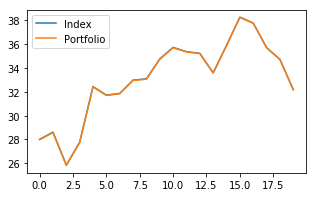

Finished Training


In [14]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print('Using device:', device)
#net.to(device)

#print(net)

# create  optimizer
optimizer = optim.Adam(net.parameters())


Nepochs = 2000
loss_hist = []

for epoch in range(Nepochs):  # loop over the dataset multiple times


    # zero the parameter gradients
    optimizer.zero_grad()


    #hedge_payoff, true_payoff, S = SimHedge(net, Ndt, S0, mu, sigma, T, Nsims, True)
    wt, Return, TVaR, TotalVal, TotalVal_index, TotalVal_T, IndexVal_T, wass_dist = SimTVaR(net, Ndt, T, Nsims, True)
    
    #print (S )
    #error = wass_dist + TVaR
    #print (error )  
    loss = torch.sum(wass_dist) + torch.sum(TVaR)
    #loss = torch.sum(-TVaR)
    #print (wt) 
    loss.backward()   
    
    #print (wt, Return, TVaR ) 
    # optimize
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    
    # plot output every 50 iterations
    if( (epoch % 50 == 0) and (epoch>1) ):
        print(epoch,end=" ")
        #print(loss.item())
        print("Wass Dist:", torch.sum(wass_dist**2))
        print("TVaR:", torch.sum(-TVaR))
        sns.distplot(np.array(IndexVal_T.detach()), hist=True, kde=True)
        sns.distplot(np.array(TotalVal_T.detach()), hist=True, kde=True)
        plt.figure(figsize=(5,3))
        plt.plot(loss_hist)
        plt.show()
        
        plt.figure(figsize=(5,3))
        plt.plot(np.array(TotalVal_index.detach())[2], label='Index')
        plt.plot(np.array(TotalVal.detach())[2], label='Portfolio')
        plt.legend()
        plt.show()
                
        #PlotHedge(net)
        #plt.plot(Return.detach())
#         plt.scatter(S[:,-1], TVaR.detach())
#         plt.scatter(S[:,-1], TVaR.detach())
#         plt.show()



print('Finished Training')